In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from scipy.stats import chi2_contingency, pointbiserialr, f_oneway
from IPython.display import display

In [2]:
MAIN_DATA = pd.read_csv("Electric_Vehicle_Data.csv")

# Total Rows & Rows with NaN (even single one of it)
print("Total rows:", len(MAIN_DATA))
print("Rows with NaN:", len(MAIN_DATA[MAIN_DATA.isnull().any(axis=1)]))
print(
    "\nThus, simply dropping all the rows with even a single NaN value as its almost a negligible number compared to total rows!"
)

# Dropping rows with NaN (even single one of it amongst the columns)
MAIN_DATA = MAIN_DATA.dropna()

# Printing all the total rows now
print("\nTotal rows Now:", len(MAIN_DATA))

Total rows: 181458
Rows with NaN: 403

Thus, simply dropping all the rows with even a single NaN value as its almost a negligible number compared to total rows!

Total rows Now: 181055


In [3]:
MAIN_DATA

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WAUTPBFF4H,King,Seattle,WA,98126.0,2017,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,0,34.0,235085336,POINT (-122.374105 47.54468),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,WAUUPBFF2J,Thurston,Olympia,WA,98502.0,2018,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,0,22.0,237896795,POINT (-122.943445 47.059252),PUGET SOUND ENERGY INC,5.306701e+10
2,5YJSA1E22H,Thurston,Lacey,WA,98516.0,2017,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,22.0,154498865,POINT (-122.78083 47.083975),PUGET SOUND ENERGY INC,5.306701e+10
3,1C4JJXP62M,Thurston,Tenino,WA,98589.0,2021,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25,0,20.0,154525493,POINT (-122.85403 46.856085),PUGET SOUND ENERGY INC,5.306701e+10
4,5YJ3E1EC9L,Yakima,Yakima,WA,98902.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,308,0,14.0,225996361,POINT (-120.524012 46.5973939),PACIFICORP,5.307700e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181453,50EA1TEA7P,Douglas,East Wenatchee,WA,98802.0,2023,LUCID,AIR,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,12.0,244207316,POINT (-120.28674 47.4176),PUD NO 1 OF DOUGLAS COUNTY,5.301795e+10
181454,1C4JJXP60N,Spokane,Spokane Valley,WA,99206.0,2022,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,0,4.0,207180774,POINT (-117.24549 47.6534),BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...,5.306301e+10
181455,5YJ3E1EA0M,King,Enumclaw,WA,98022.0,2021,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,31.0,161934202,POINT (-121.98953 47.20347),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
181456,5YJ3E1EC8L,Clark,Vancouver,WA,98682.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,308,0,18.0,100859650,POINT (-122.5286031 45.6686601),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,5.301104e+10


In [4]:
def get_unique_value_counts(data):
    """
    Compute the counts of unique values in the first column of data.

    Args:
    data (numpy.ndarray): The input data containing at least one column.

    Returns:
    list of int: A list of counts corresponding to each unique value.
    """
    unique_values, counts = np.unique(data[:, 0], return_counts=True)
    return list(counts)

def compute_buc_patterns(data, minsup):
    """
    Compute patterns with minimum support using the BUC algorithm.

    Args:
    data (numpy.ndarray): The input data as a 2D array.
    minsup (int): The minimum support threshold for patterns.

    Returns:
    pandas.DataFrame: A DataFrame containing patterns that meet the minimum support threshold.
    """
    patterns = []

    def recursive_compute(data, current_pattern=[]):
        if data.shape[1] == 0:
            patterns.append(current_pattern + [len(data)])
            return

        sorted_data = data[data[:, 0].argsort()]
        data_counts = get_unique_value_counts(sorted_data)
        i = 0

        for support in data_counts:
            if support >= minsup:
                new_pattern = current_pattern + [sorted_data[i, 0]]
                recursive_compute(sorted_data[i:i+support, 1:], new_pattern)
            i += support

        new_pattern = current_pattern + ["ALL"]
        recursive_compute(data[:, 1:], new_pattern)

    recursive_compute(data, [])

    result_df = pd.DataFrame(patterns, columns=list(MAIN_DATA.columns) + ["count_buc"])
    return result_df

min_support_threshold = 100
result_patterns_df = compute_buc_patterns(MAIN_DATA.values, min_support_threshold)

In [5]:
print("BUC Algorithm result with minimum support 100")
result_patterns_df

BUC Algorithm result with minimum support 100


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,count_buc
0,1G1FY6S02P,ALL,ALL,WA,ALL,2023,CHEVROLET,BOLT EUV,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,ALL,ALL,ALL,ALL,ALL,109
1,1G1FY6S02P,ALL,ALL,WA,ALL,2023,CHEVROLET,BOLT EUV,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,ALL,ALL,ALL,ALL,ALL,ALL,109
2,1G1FY6S02P,ALL,ALL,WA,ALL,2023,CHEVROLET,BOLT EUV,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,ALL,0,ALL,ALL,ALL,ALL,ALL,109
3,1G1FY6S02P,ALL,ALL,WA,ALL,2023,CHEVROLET,BOLT EUV,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,ALL,ALL,ALL,ALL,ALL,ALL,ALL,109
4,1G1FY6S02P,ALL,ALL,WA,ALL,2023,CHEVROLET,BOLT EUV,Battery Electric Vehicle (BEV),ALL,0,0,ALL,ALL,ALL,ALL,ALL,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4949593,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,53073001102.0,140
4949594,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,53073001202.0,185
4949595,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,53073010405.0,196
4949596,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,53073010701.0,103


In [6]:
num_col = MAIN_DATA.shape[1]
minsup = 100
def BUC(dataFrame, begin, end):
    if end - num_col >= 0:
        return
   
    column = dataFrame.columns[end]
    count_dataFrame = dataFrame.groupby(column)[column].count().reset_index(name='count').sort_values(by='count', ascending=False)

    for i in range(len(count_dataFrame)):
        if count_dataFrame.iloc[i, 1] >= minsup:
            value = count_dataFrame.iloc[i, 0]
           
            temp_dataFrame = dataFrame.loc[dataFrame[dataFrame.columns[end]] == value, dataFrame.columns[begin:end + 1]].head(1)
            temp_dataFrame = ' ~ '.join(temp_dataFrame.iloc[0].astype(str))

            next_dataFrame = dataFrame[dataFrame[dataFrame.columns[end]] == value]
            BUC(next_dataFrame, begin, end + 1)

In [7]:
sup = []
runtime = []

for i in range(100, 1000, 100):
    minsup = i

    initialTime = time.time()
    s = 0
   
    n = 1 # Number of iterations to average on
    for idx in range(n):
        for j in range(num_col):
            BUC(MAIN_DATA, j, j)
        s += minsup
       
    finalTime = time.time()
   
    sup.append(s/n)
    runtime.append(finalTime - initialTime)

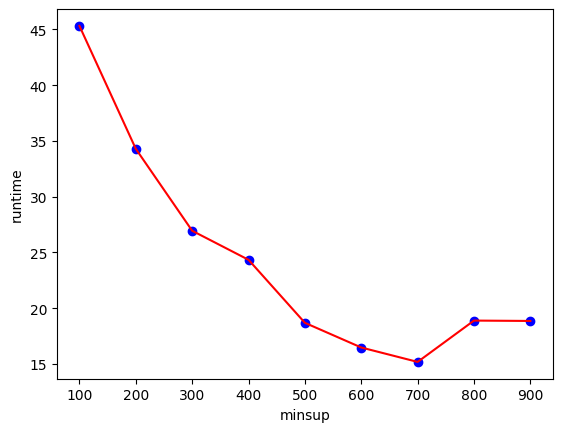

In [8]:
plt.plot(sup, runtime, color='red', linestyle='-')
plt.scatter(sup, runtime, color='blue', marker='o', label='Data Points')
plt.xlabel('minsup')
plt.ylabel('runtime')
plt.show()

In [9]:
# Calculate memory usage in KB
totalKBMemory = MAIN_DATA.memory_usage().sum() / 1024

# Change main_memory_kb from 100 to 4000 in steps of 300
# Calculate the time taken for each main_memory_kb
# Plot the graph of time vs main_memory_kb
listMemory = []
listTime = []

for mainKBMemory in range(100, 4000, 300):
    number_of_pages = int(totalKBMemory / mainKBMemory)
    initialTime = time.time()

    # Create pages and run BUC on each page
    for i in range(number_of_pages):
        dataFrame = MAIN_DATA.iloc[i * num_col:(i + 1) * num_col, :]
        for j in range(num_col):
            BUC(dataFrame, j, j)

    finalTime = time.time()
    listTime.append(finalTime - initialTime)
    listMemory.append(mainKBMemory)

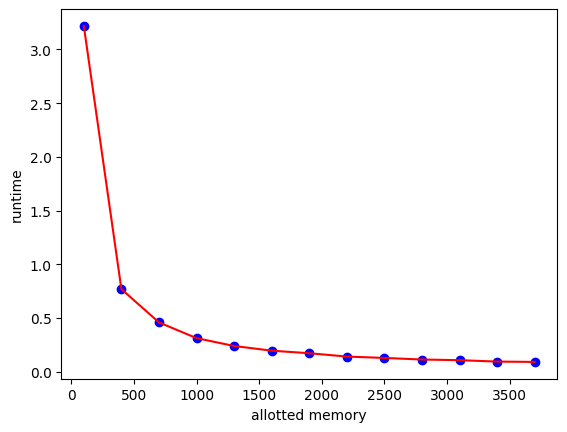

In [10]:
plt.plot(listMemory, listTime, color='red')
plt.scatter(listMemory, listTime, color='blue')
plt.xlabel('allotted memory')
plt.ylabel('runtime')
plt.show()